In [1]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Reshape, Dropout, Dense, Activation
from keras import layers, optimizers
import tensorflow as tf

In [3]:
num_classes = 1
input_shape = (75, 32)
image_size = 75  # We'll resize input images to this size
patch_size = 5  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size)
projection_dim = 100
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
# DropOut Rate
drop_rate = 0.2

In [4]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        #x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [5]:

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size' : self.patch_size, 
            
        })
        
        return config
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, 1, 1],
            strides=[1, self.patch_size, 1, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [6]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches' : self.num_patches, 
            'projection_dim' : projection_dim, 
            
        })
        
        return config
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        
        #print(patch,positions)
        #temp = self.position_embedding(positions)
        #temp = tf.reshape(temp,(1,int(temp.shape[0]),int(temp.shape[1])))
        #encoded = layers.Add()([self.projection(patch), temp])
        #print(temp,encoded)
        
        return encoded

In [7]:
def create_vit_classifier(inputs):
    
    filters = [32, 64, 96, 128, 256] 

    e = Conv1D(filters[1], 3, padding = 'same')(inputs) 
    e = Dropout(drop_rate)(e, training=True)
    e = MaxPooling1D(2, padding='same')(e)

    e = Conv1D(filters[0], 3, padding = 'same')(e) 
    e = Dropout(drop_rate)(e, training=True)
    e = MaxPooling1D(2, padding='same')(e)
    
    e = Conv1D(filters[0], 3, padding = 'same')(e) 
    e = Dropout(drop_rate)(e, training=True)
    e = MaxPooling1D(2, padding='same')(e)
    
        
    e = Conv1D(filters[0], 3, padding = 'same')(e) 
    e = Dropout(drop_rate)(e, training=True)
    e = MaxPooling1D(5, padding='same')(e)
    
    
    #print(e)
    inputreshaped = layers.Reshape((75,1,32))(e)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputreshaped)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    
    #print(patches, encoded_patches)
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        #encoded_patches = convF1(encoded_patches, projection_dim,11, 0.1)
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        #attention_output = convF1(attention_output, projection_dim,11, 0.1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        #x3 = convF1(x3, projection_dim,11, 0.1)

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    #print(representation, encoded_patches)

    # Add MLP.
    features = mlp(representation, hidden_units=[1000,500], dropout_rate=0.5)
    # Classify outputs.

    return features

In [8]:
inp1 = layers.Input(shape=(3000,3),name='input_layer')

features = create_vit_classifier(inp1)
#features = Reshape((6000,1))(features)

e = Dense(1)(features)
o = Activation('linear', name='output_layer')(e)
model = Model(inputs=[inp1], outputs=o)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 3000, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3000, 64)     640         input_layer[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 3000, 64)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1500, 64)     0           dropout[0]

In [9]:
testdata = np.load('TestDataMag1000.npz')
x_test = testdata['x_test']
y_test = testdata['y_test']
net_code = testdata['net_code']
rec_type = testdata['rec_type']
eq_id = testdata['eq_id']
eq_depth = testdata['eq_depth']
eq_mag = testdata['eq_mag']
mag_type = testdata['mag_type']
mag_auth = testdata['mag_auth']
eq_dist = testdata['eq_dist']
snr = testdata['snr']
trace_name = testdata['trace_name']
S_P = testdata['S_P']
baz_test = testdata['baz_test']
assert not np.any(np.isnan(x_test).any())
assert not np.any(np.isnan(y_test).any())

assert not np.any(np.isnan(x_test).any())
assert not np.any(np.isnan(y_test).any())

In [11]:

import keras
from keras.models import load_model
model = load_model(r'VIT_MAGNITUDE_157.h5', custom_objects={ "PatchEncoder":PatchEncoder,
                                                             "Patches":Patches,
                                                             "mlp":mlp})


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
#predic = model.predict(x_test, batch_size=512, verbose=1)
predic=[]
for i in range(0,100):
    print(i)
    out = model.predict(x_test, batch_size=512, verbose=2)
    out = np.array(out)
    predic.append(out)

predic = np.mean(predic,0)

diff = []
for i, v in enumerate(y_test):
    pre = predic[i]
    d = v[0] - pre
    diff.append(d)

diff = np.array(diff)
(np.round(np.mean(diff), 2)), (np.round(np.mean(np.abs(diff)), 2)), (np.round(np.std(diff), 2))

0


/root/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(-0.0, 0.11, 0.16)

Text(0, 0.5, 'Predicted')

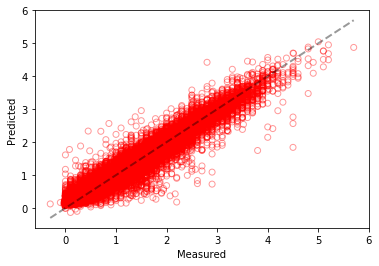

In [13]:
fig4, ax = plt.subplots()
ax.scatter(y_test, predic, alpha = 0.4, facecolors='none', edgecolors='r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

(-0.00019659816, 0.11213411, 0.16483685)

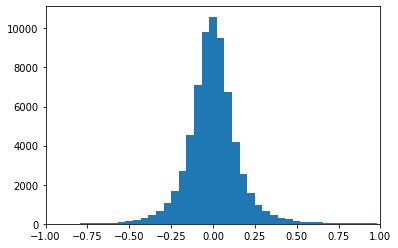

In [15]:
plt.hist(diff, bins=100)
plt.xlim([-1,1])
np.mean(np.abs(diff)), np.std(diff)

Text(0, 0.5, 'Predicted')

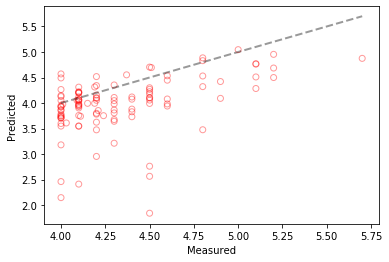

In [16]:
indx4 = np.where(y_test>=4)[0]

fig4, ax = plt.subplots()
ax.scatter(y_test[indx4], predic[indx4], alpha = 0.4, facecolors='none', edgecolors='r')
ax.plot([y_test[indx4].min(), y_test[indx4].max()], [y_test[indx4].min(), y_test[indx4].max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

In [17]:
#M4

dif4 = y_test[indx4] -  predic[indx4]
np.mean(np.abs(dif4)), np.std(dif4)

(0.4180240876891396, 0.5004072299384517)